# Análise Exploratória de Dados: Clima vs. Testemunha

In [43]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

engine = create_engine('sqlite:///../database/clima_prod.db')
df_performance = pd.read_sql('lote_performance_summary', engine)
df_iot = pd.read_sql('daily_iot_summary', engine)
df_acompanhamento = pd.read_sql('acompanhamento_lotes_data', engine)

## 1. Limpeza e Preparação dos Dados
Nesta seção, os dados das tabelas `lote_performance_summary`, `daily_iot_summary` e `acompanhamento_lotes_data` são carregados, limpos e unidos em um único DataFrame para análise. As principais etapas incluem a padronização de nomes de colunas e valores, conversão de tipos de dados e a fusão das tabelas com base no `lote_composto` e `idade_lote`.

In [44]:
df_acompanhamento['lote_composto'] = df_acompanhamento['lote_composto'].str.replace('_', '-')
df_acompanhamento = df_acompanhamento.rename(columns={'Idade': 'idade_lote'})
df_performance['data_alojamento'] = pd.to_datetime(df_performance['data_alojamento'], format='%d/%m/%Y')
df_iot['Data'] = pd.to_datetime(df_iot['Data'], format='%d/%m/%Y', errors='coerce')
df_acompanhamento['Data'] = pd.to_datetime(df_acompanhamento['Data'], format='%d/%m/%Y', errors='coerce')
df_iot['max_valor'] = pd.to_numeric(df_iot['max_valor'], errors='coerce')
df_iot['min_valor'] = pd.to_numeric(df_iot['min_valor'], errors='coerce')
df_merged = pd.merge(df_iot, df_acompanhamento, on=['lote_composto', 'idade_lote'], how='outer', suffixes=('_iot', '_acomp'))
df_final = pd.merge(df_merged, df_performance, on='lote_composto', how='left', suffixes=('', '_perf'))
lotes_interesse = ['1282-19', '1283-19']
df_final = df_final[df_final['lote_composto'].isin(lotes_interesse)].copy()
df_final['teste_realizado'] = df_final['teste_realizado'].replace('CLIMA200', 'CLIMA')
print('Dados prontos para análise.')

Dados prontos para análise.


## 2. Análise Comparativa de Indicadores de Desempenho
Os gráficos de barras a seguir comparam os principais indicadores de desempenho (KPIs) entre os tratamentos 'CLIMA' e 'TESTEMUNHA'. Isso nos permite ter uma visão geral de qual tratamento obteve melhores resultados em termos de mortalidade, conversão alimentar, IEP, peso médio e remuneração.

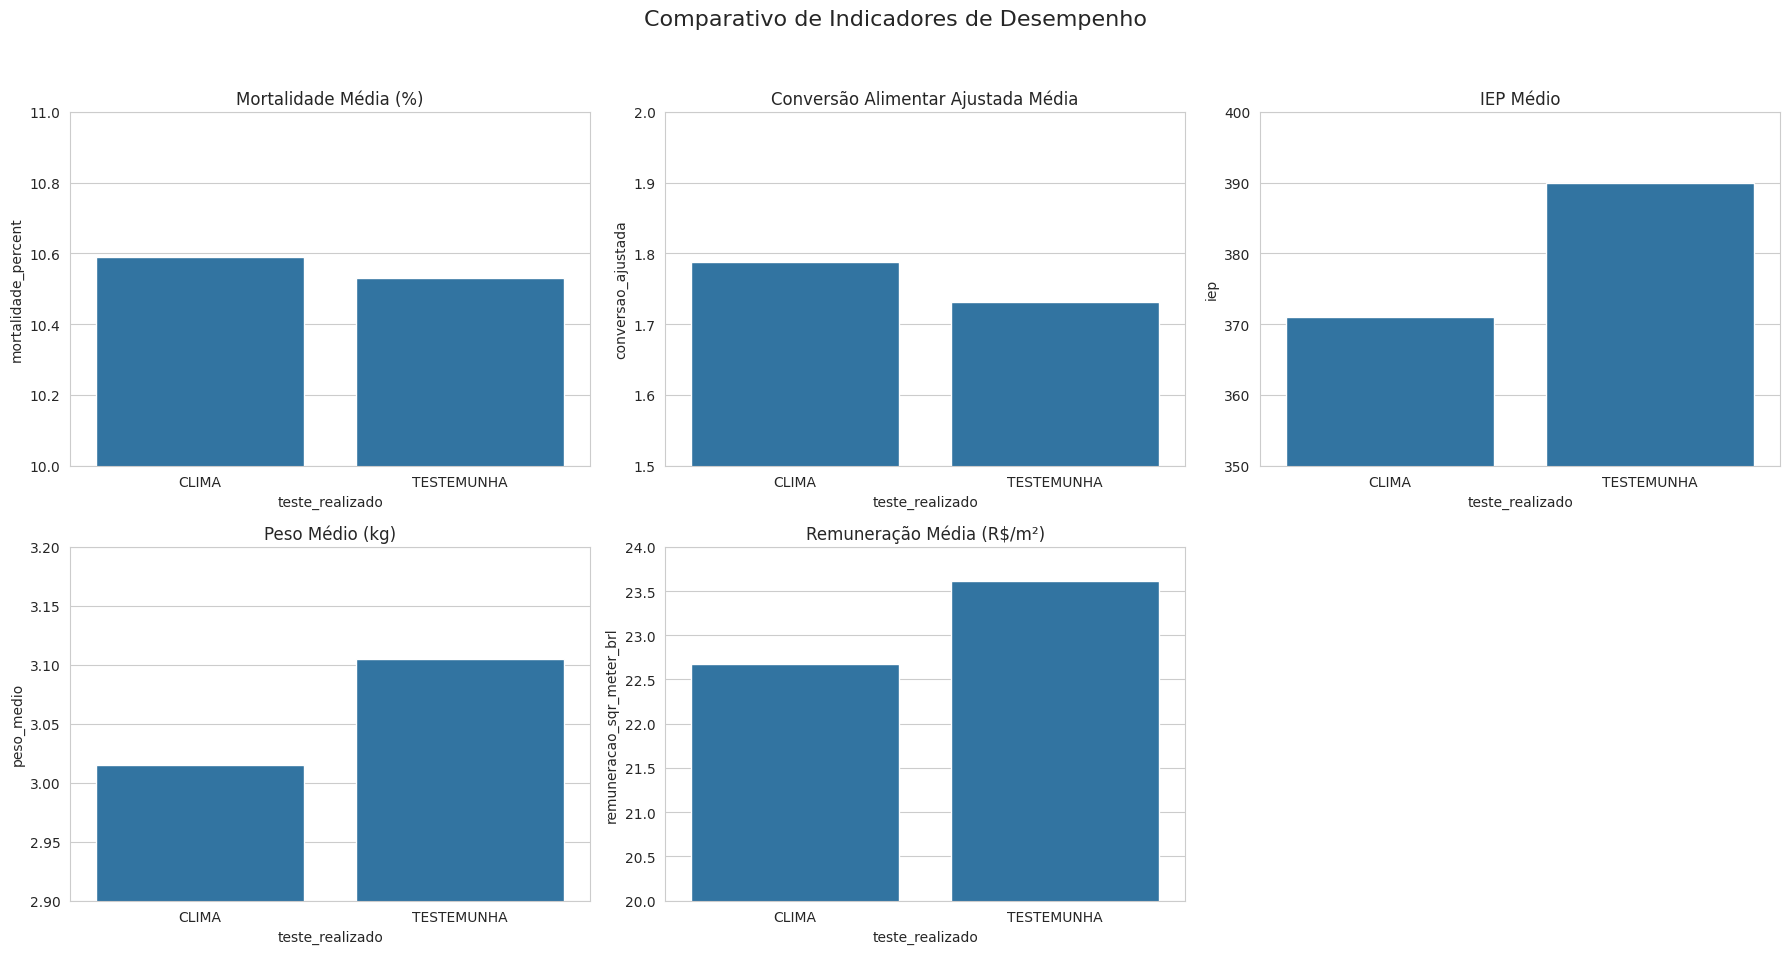

In [45]:
df_perf_summary = df_final.groupby('teste_realizado')[['mortalidade_percent', 'conversao_ajustada', 'iep', 'peso_medio', 'remuneracao_sqr_meter_brl']].mean().reset_index()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparativo de Indicadores de Desempenho', fontsize=16)

sns.barplot(data=df_perf_summary, x='teste_realizado', y='mortalidade_percent', ax=axes[0, 0])
axes[0, 0].set_title('Mortalidade Média (%)')
axes[0, 0].set_ylim(10, 11)

sns.barplot(data=df_perf_summary, x='teste_realizado', y='conversao_ajustada', ax=axes[0, 1])
axes[0, 1].set_title('Conversão Alimentar Ajustada Média')
axes[0, 1].set_ylim(1.5, 2)

sns.barplot(data=df_perf_summary, x='teste_realizado', y='iep', ax=axes[0, 2])
axes[0, 2].set_title('IEP Médio')
axes[0, 2].set_ylim(350, 400)

sns.barplot(data=df_perf_summary, x='teste_realizado', y='peso_medio', ax=axes[1, 0])
axes[1, 0].set_title('Peso Médio (kg)')
axes[1, 0].set_ylim(2.9, 3.2)

sns.barplot(data=df_perf_summary, x='teste_realizado', y='remuneracao_sqr_meter_brl', ax=axes[1, 1])
axes[1, 1].set_title('Remuneração Média (R$/m²)')
axes[1, 1].set_ylim(20, 24)


fig.delaxes(axes[1,2])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 3. Análise da Ambiência
A seguir, analisamos a evolução das principais variáveis de ambiência (Temperatura, Umidade Relativa e Amônia) ao longo da idade do lote. Os gráficos de linha comparam o comportamento dessas variáveis entre os tratamentos, permitindo identificar diferenças no controle ambiental.

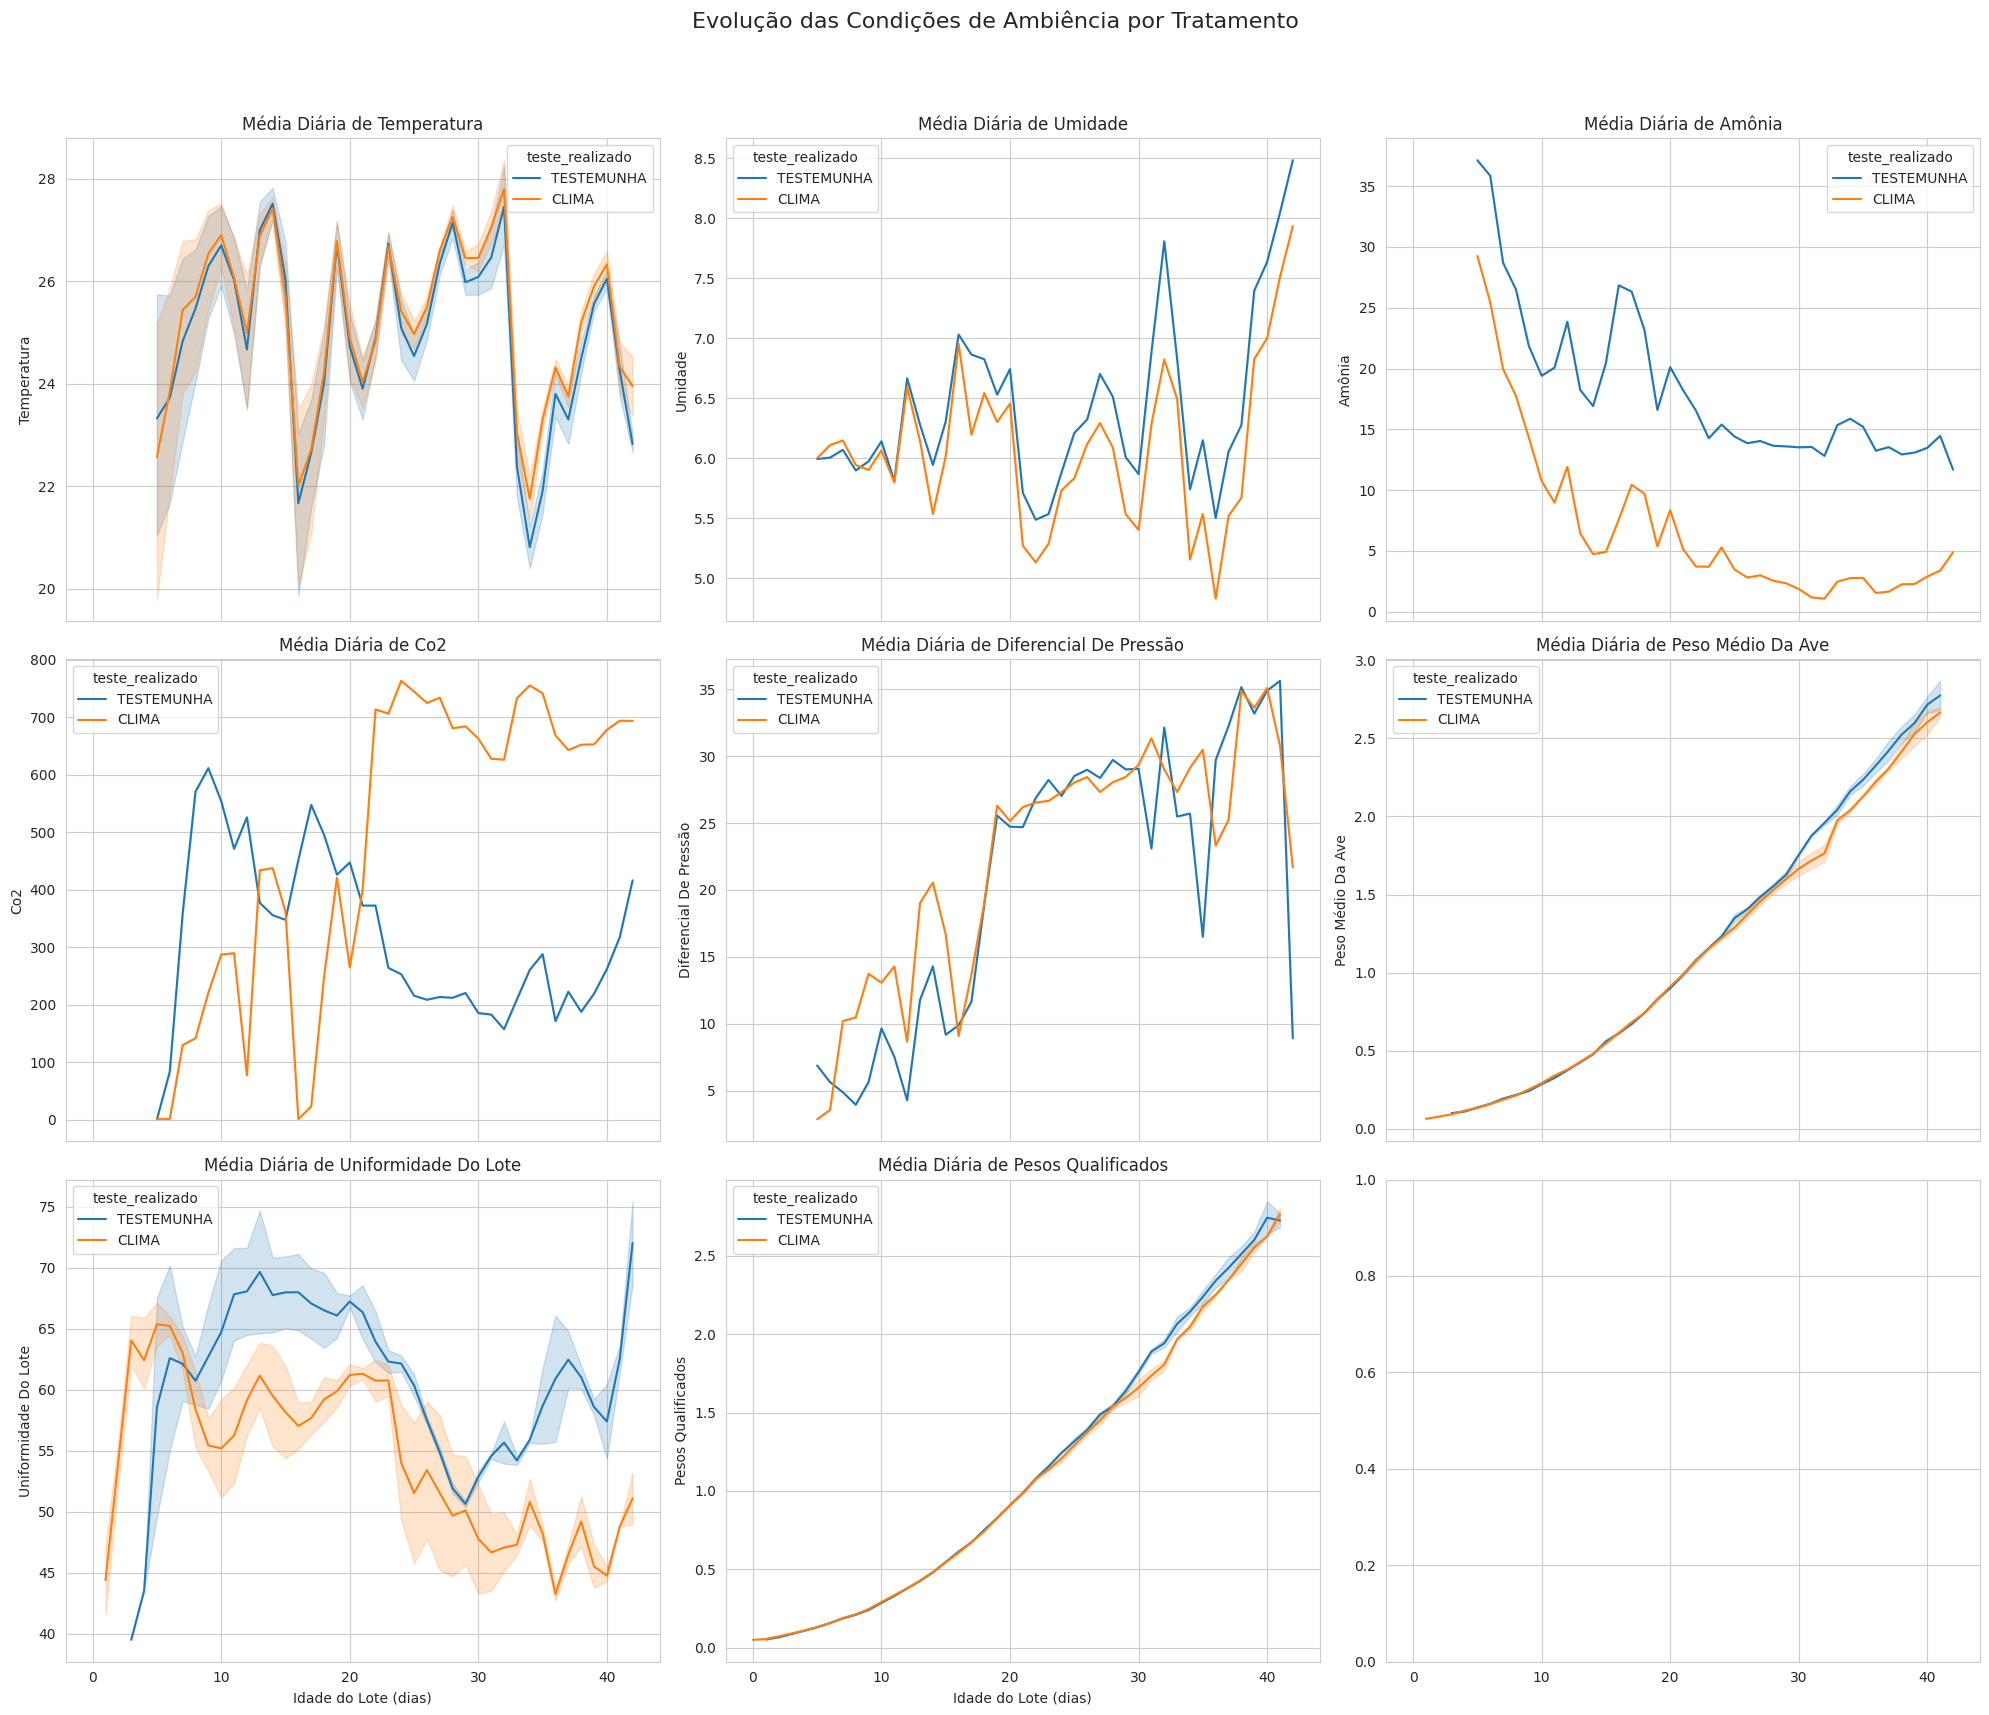

In [46]:
grandezas_amb_interesse = ['TEMPERATURA', 'UMIDADE', 'AMÔNIA', 'CO2', 'DIFERENCIAL DE PRESSÃO', 'PESO MÉDIO DA AVE', 'UNIFORMIDADE DO LOTE', 'PESOS QUALIFICADOS']
df_amb = df_final[df_final['Grandeza_iot'].isin(grandezas_amb_interesse)]

fig, axes = plt.subplots(3, 3, figsize=(20, 18), sharex=True)
fig.suptitle('Evolução das Condições de Ambiência por Tratamento', fontsize=16)


# Plotar cada grandeza em um subplot separado trazendo a média diária (average_valor) e em hue a zona maxima (max_valor) e mínima (min_valor)
for i, grandeza in enumerate(grandezas_amb_interesse):
    sns.lineplot(data=df_amb[df_amb['Grandeza_iot'] == grandeza], x='idade_lote', y='average_valor', hue='teste_realizado', ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'Média Diária de {grandeza.title()}')
    axes[i // 3, i % 3].set_ylabel(grandeza.title())
    axes[i // 3, i % 3].set_xlabel('Idade do Lote (dias)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Análise do Acompanhamento Diário
Estes gráficos mostram a evolução da mortalidade diária e do consumo de ração. A comparação entre os tratamentos pode revelar insights sobre o bem-estar e o desenvolvimento das aves ao longo do ciclo de produção.

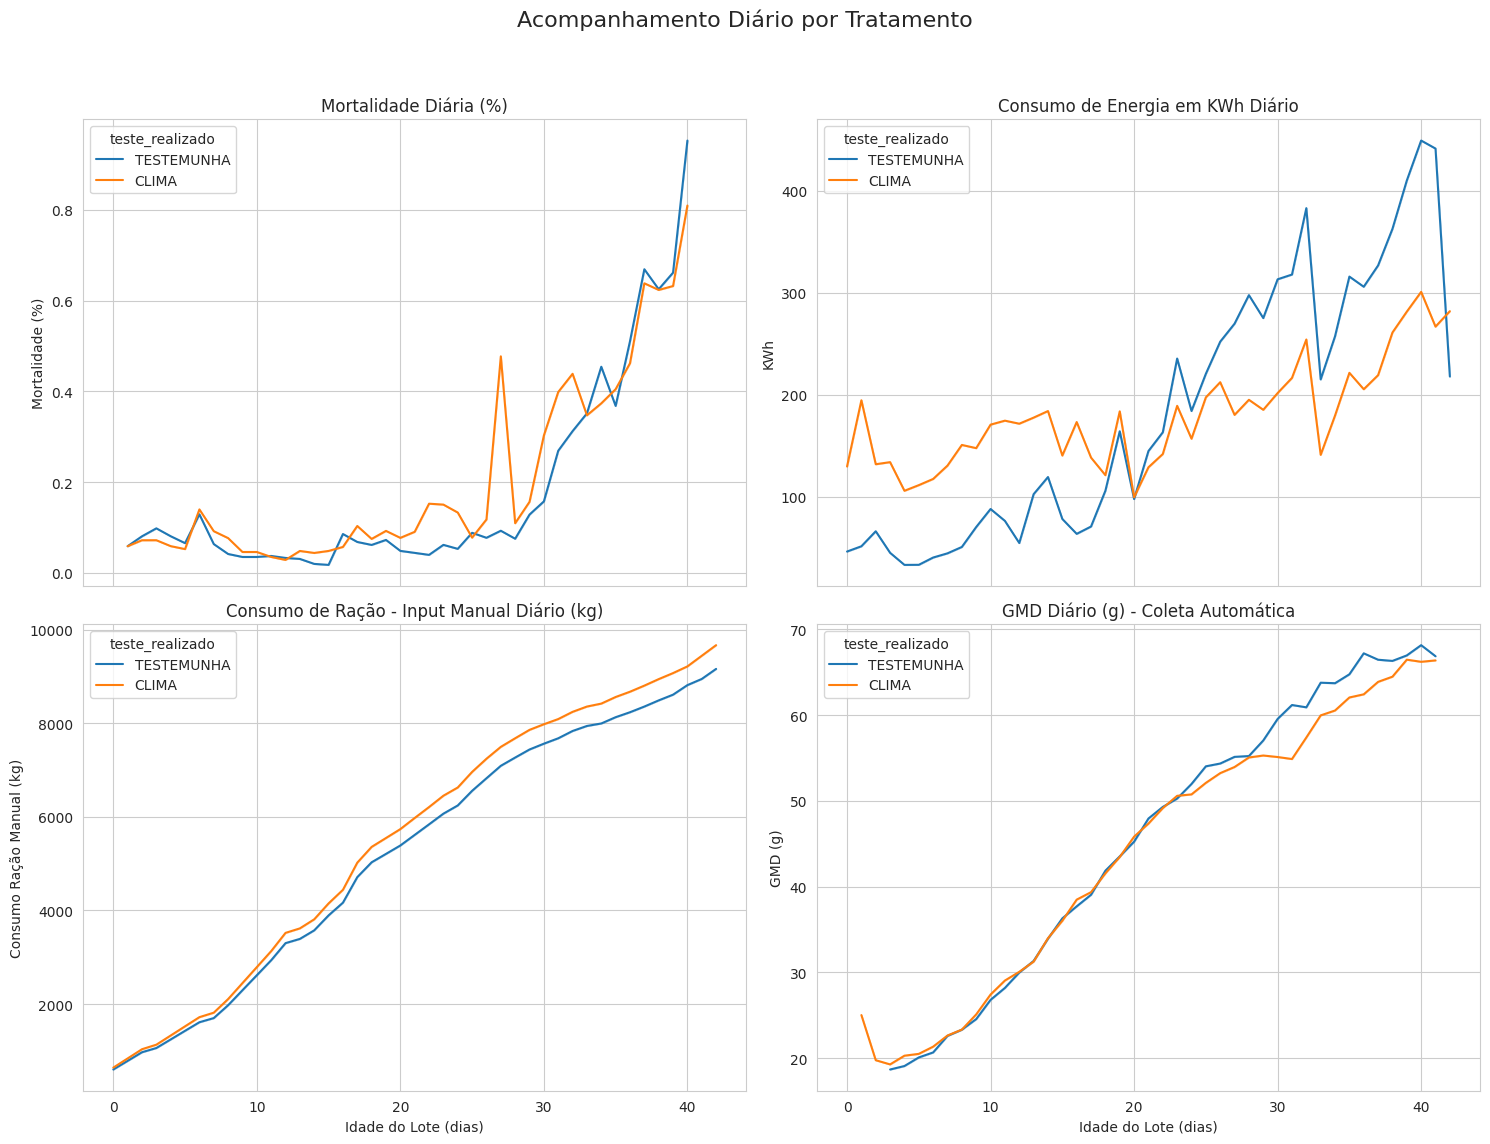

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
fig.suptitle('Acompanhamento Diário por Tratamento', fontsize=16)

sns.lineplot(data=df_final, x='idade_lote', y='Mortalidade_percent', hue='teste_realizado', ax=axes[0, 0])
axes[0, 0].set_title('Mortalidade Diária (%)')
axes[0, 0].set_ylabel('Mortalidade (%)')
axes[0, 0].set_xlabel('Idade do Lote (dias)')


sns.lineplot(data=df_final, x='idade_lote', y='Consumo_automatico_kwh', hue='teste_realizado', ax=axes[0, 1])
axes[0, 1].set_title('Consumo de Energia em KWh Diário')
axes[0, 1].set_ylabel('KWh')
axes[0, 1].set_xlabel('Idade do Lote (dias)')

sns.lineplot(data=df_final, x='idade_lote', y='Consumo_manual_kg', hue='teste_realizado', ax=axes[1, 0])
axes[1, 0].set_title('Consumo de Ração - Input Manual Diário (kg)')
axes[1, 0].set_ylabel('Consumo Ração Manual (kg)')
axes[1, 0].set_xlabel('Idade do Lote (dias)')

sns.lineplot(data=df_final, x='idade_lote', y='GMD_automatico_g', hue='teste_realizado', ax=axes[1, 1])
axes[1, 1].set_title('GMD Diário (g) - Coleta Automática')
axes[1, 1].set_ylabel('GMD (g)')
axes[1, 1].set_xlabel('Idade do Lote (dias)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()